# Modify Below

### Note: Running times are not reproducible

In [1]:
n_trial = 10
n_epoch = 10
recur_neuron_list = list(range(100, 1001, 100)) 

# Import Packages


In [2]:
try:
  import tension
except ImportError:
  !git clone https://github.com/zhenruiliao/tension.git tension
  !pip install -e tension
  print('Stopping RUNTIME! Please run again.')
  import os
  os.kill(os.getpid(), 9)

In [3]:
import matplotlib.pyplot as plt
import time 

import numpy as np
import tensorflow as tf

from tension.models import NoFeedbackESN, FullFORCEModel
from tension.callbacks import TimeHistory

import gc
 
print(tf.__version__)

2.8.2


# Define Sum of Sinusoid Target

From https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0191527

In [4]:
def fullforce_oscillation_test(dt, showplots=0):
    dt_per_s = round(1/dt)
    
    # From the paper, and the online demo:
    t = np.expand_dims(np.linspace(0,2,2*dt_per_s+1),1)
    omega = np.zeros((2*dt_per_s+1,1))
    omega = np.linspace(2*np.pi, 6*np.pi, 1*dt_per_s+1)
    targ = np.zeros((2*dt_per_s+1,1))
    targ[0:(1*dt_per_s+1),0] = np.sin(t[0:(1*dt_per_s+1),0]*omega)
    targ[1*dt_per_s:(2*dt_per_s+1)] = -np.flipud(targ[0:(1*dt_per_s+1)])
    
    # A simpler example: just a sine wave
    '''
    t = np.expand_dims(np.linspace(0,2,2*dt_per_s+1),1)
    omega = np.ones((2*dt_per_s+1,1)) * 4 *np.pi
    targ = np.sin(t*omega)
    '''
    
    # A slightly harder example: sum of sine waves
    t = np.expand_dims(np.linspace(0,2,2*dt_per_s+1),1)
    omega = np.ones((2*dt_per_s+1,1)) * 4 *np.pi
    targ = np.sin(t*2*omega) * np.sin(t*omega/4)
    
    inp = np.zeros(targ.shape)
    inp[0:round(0.05*dt_per_s),0] = np.ones((round(0.05*dt_per_s)))
    hints = np.zeros(targ.shape)

    if showplots == 1:
        plt.figure()
        plt.plot(targ)
        plt.plot(hints)
        plt.plot(inp)
        plt.legend(['Target','Hints','Input'])
    
    return inp, targ, hints

# Create input and target

(801, 2) (801, 1)


34

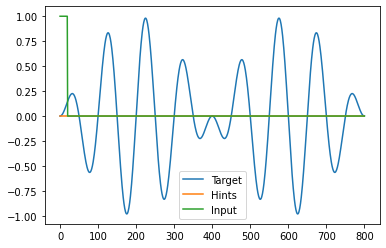

In [5]:
dt = 0.0025
tau = 10 * dt
inp, targ, hints = fullforce_oscillation_test(dt=dt, showplots=1)

input1 = np.concatenate([inp, hints], axis=1).astype(np.float32)
targ = targ.astype(np.float32)
hd = hints.shape[-1]
m = targ.shape[1]
print(input1.shape, targ.shape)

verbose = 1
gc.collect()

# Find running time by training using tension



In [6]:
%%time 

tensorforce_time = np.zeros((len(recur_neuron_list), 3))
for n_iter, n_recur in enumerate(recur_neuron_list):
  ffmodel_time = []
  for i in range(n_trial):  
      print(n_recur,' ', i+1)
      ff_esn = NoFeedbackESN(dtdivtau=dt/tau, units=n_recur, output_size=m, activation='tanh')
      ffmodel = FullFORCEModel(force_layer=ff_esn, target_output_kernel_trainable=False, hint_dim=hd)  
      ffmodel.compile(metrics=["mae", "mse"])  
      ffmodel_time_callback = TimeHistory()
      ffmodel_history = ffmodel.fit(x=input1, 
                                    y=targ, 
                                    epochs=n_epoch, 
                                    callbacks=[ffmodel_time_callback], 
                                    verbose=verbose) 
      ffmodel_time.append(np.mean(ffmodel_time_callback.times))
      del ffmodel, ff_esn
      gc.collect()
  assert len(ffmodel_time) == n_trial
  tensorforce_time[n_iter,0] = n_recur
  tensorforce_time[n_iter,1] = np.mean(ffmodel_time)
  tensorforce_time[n_iter,2] = np.std(ffmodel_time, ddof=1)

100   1
Epoch 1/10
801/801 [==============================] - 8s 5ms/step - mae: 0.0411 - mse: 0.0029
Epoch 2/10
801/801 [==============================] - 4s 5ms/step - mae: 0.0425 - mse: 0.0028
Epoch 3/10
801/801 [==============================] - 4s 5ms/step - mae: 0.0453 - mse: 0.0040
Epoch 4/10
801/801 [==============================] - 4s 5ms/step - mae: 0.0332 - mse: 0.0018
Epoch 5/10
801/801 [==============================] - 3s 3ms/step - mae: 0.0402 - mse: 0.0023
Epoch 6/10
801/801 [==============================] - 2s 2ms/step - mae: 0.0357 - mse: 0.0021
Epoch 7/10
801/801 [==============================] - 2s 2ms/step - mae: 0.0272 - mse: 0.0011
Epoch 8/10
801/801 [==============================] - 2s 2ms/step - mae: 0.0271 - mse: 0.0011
Epoch 9/10
801/801 [==============================] - 2s 2ms/step - mae: 0.0260 - mse: 0.0011
Epoch 10/10
801/801 [==============================] - 2s 2ms/step - mae: 0.0233 - mse: 8.3619e-04
100   2
Epoch 1/10
801/801 [===================

# Find running time by using original implementation in the dePasquale paper 

Download original full-FORCE implementation from DePasquale et al. https://zenodo.org/record/1154965#.YomQvNrMJPY

In [7]:
!wget https://zenodo.org/record/1154965/files/briandepasquale/full-FORCE-demos-v1.0.2.zip 
!unzip full-FORCE-demos-v1.0.2.zip
!mv briandepasquale-full-FORCE-demos-c354aa7/Python/FF_Demo.py .

--2022-09-15 03:53:48--  https://zenodo.org/record/1154965/files/briandepasquale/full-FORCE-demos-v1.0.2.zip
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 478928 (468K) [application/octet-stream]
Saving to: ‘full-FORCE-demos-v1.0.2.zip’

full-FORCE-demos-v1 100%[===================>] 467.70K   549KB/s    in 0.9s    

2022-09-15 03:53:51 (549 KB/s) - ‘full-FORCE-demos-v1.0.2.zip’ saved [478928/478928]

Archive:  full-FORCE-demos-v1.0.2.zip
c354aa7414877b4ee07ac7d1e1a7b6db305ab41e
   creating: briandepasquale-full-FORCE-demos-c354aa7/
  inflating: briandepasquale-full-FORCE-demos-c354aa7/LICENSE  
   creating: briandepasquale-full-FORCE-demos-c354aa7/Matlab/
  inflating: briandepasquale-full-FORCE-demos-c354aa7/Matlab/demo_oscillation.m  
  inflating: briandepasquale-full-FORCE-demos-c354aa7/Matlab/demo_ready_set_go.m  
   creating: briandepasquale-full-F

In [8]:
import FF_Demo

Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network

/content/FF_Demo.py:251: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  training_fig = plt.figure()


..
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 of 1, 10 trials: 
..........
Done training!
Initializing...
Training network...
Batch 1 o

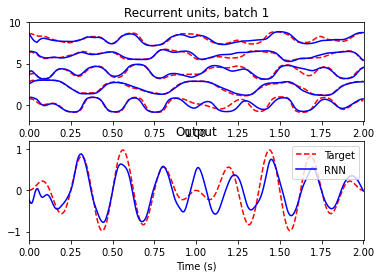

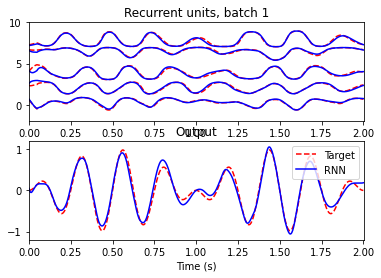

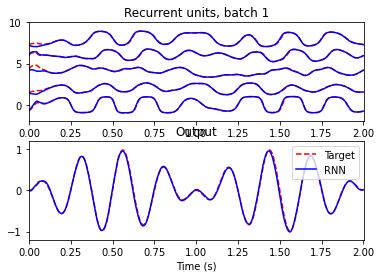

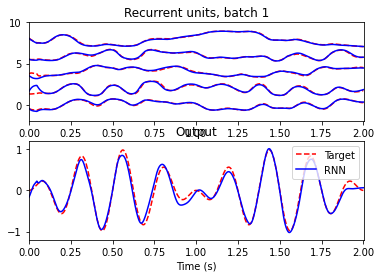

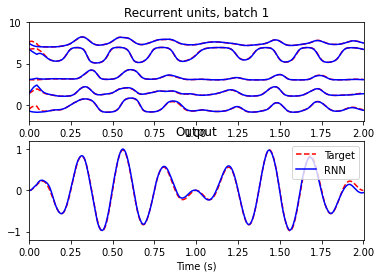

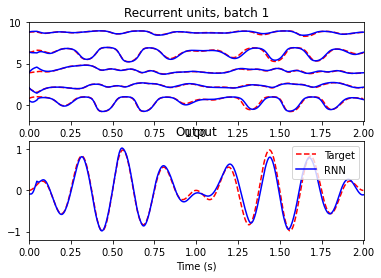

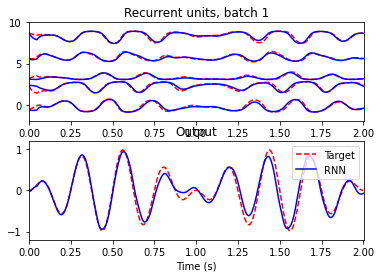

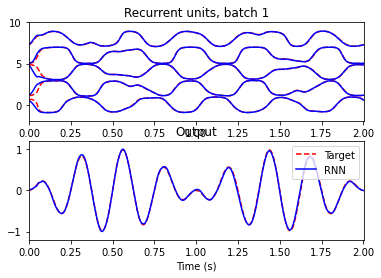

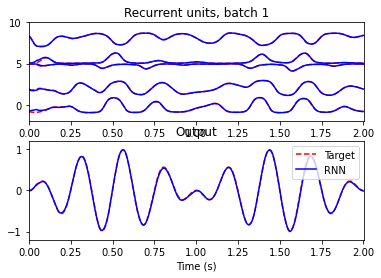

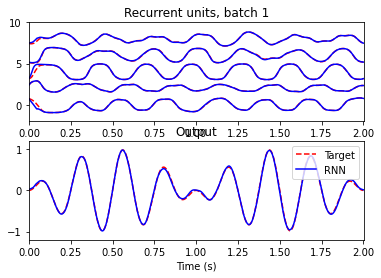

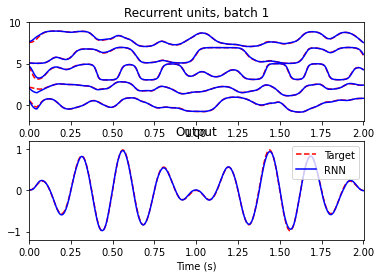

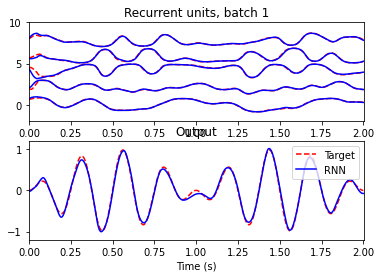

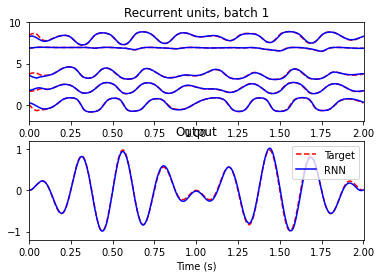

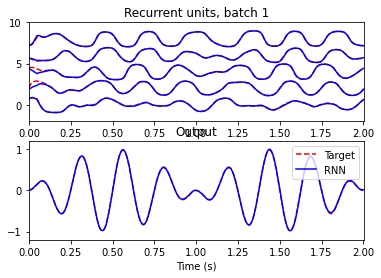

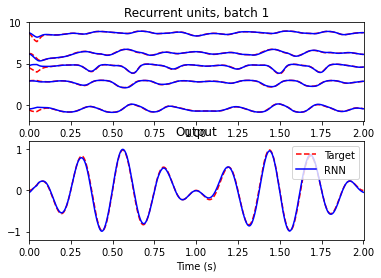

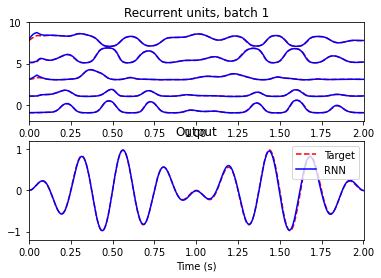

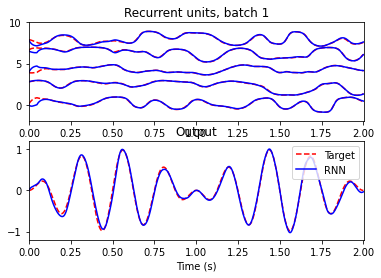

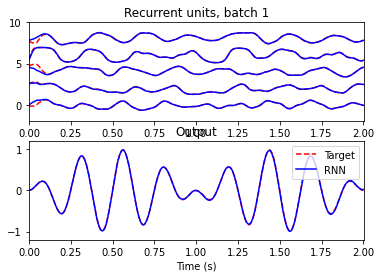

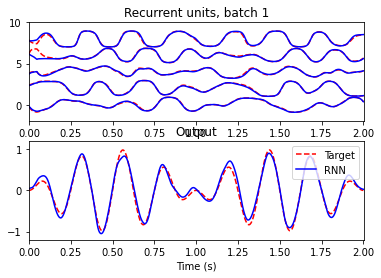

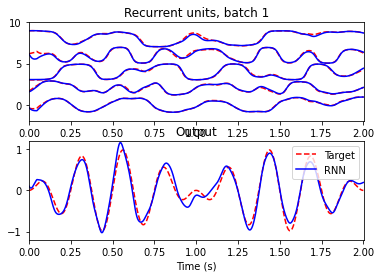

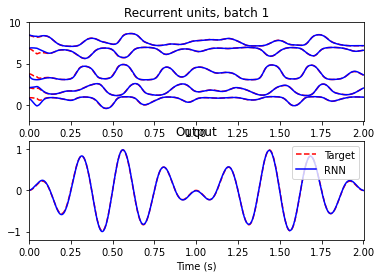

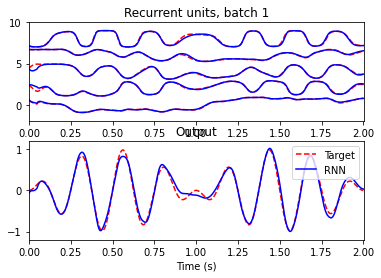

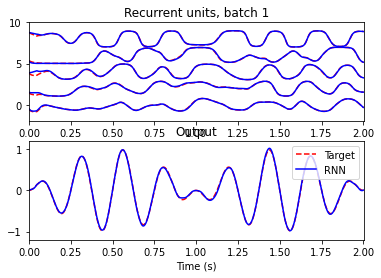

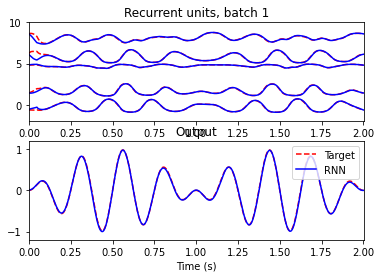

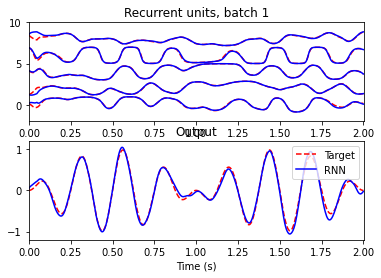

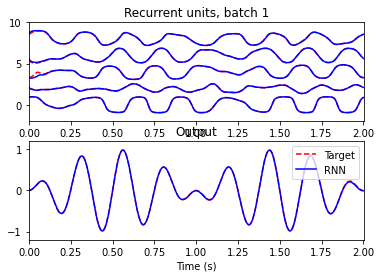

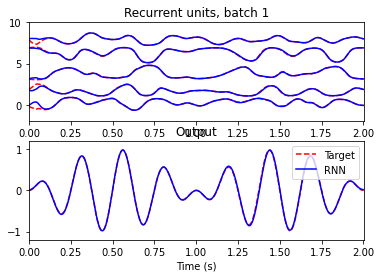

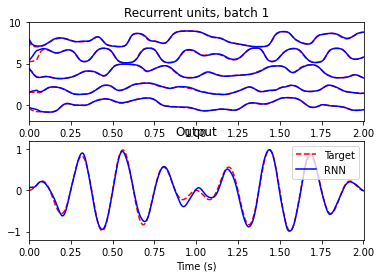

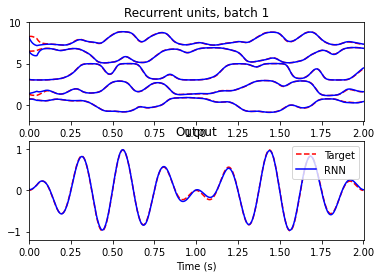

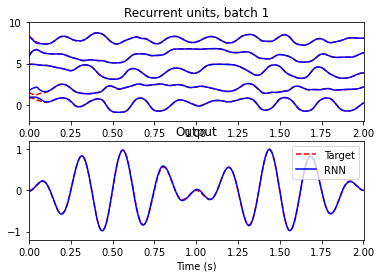

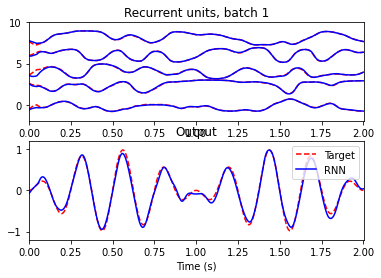

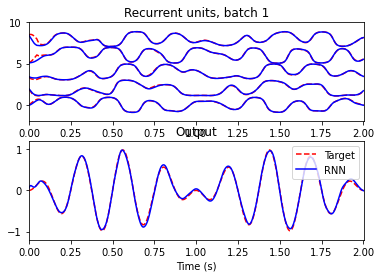

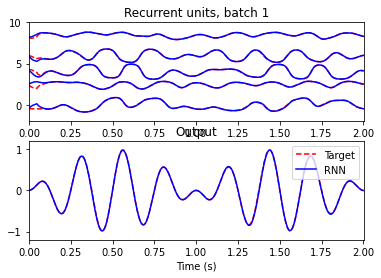

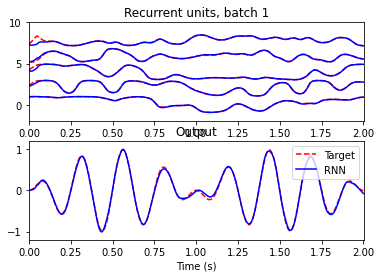

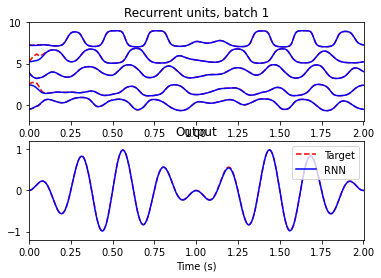

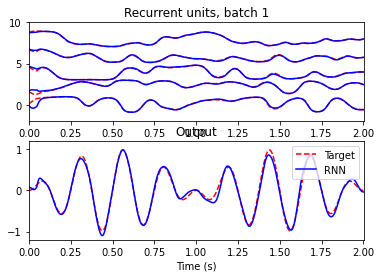

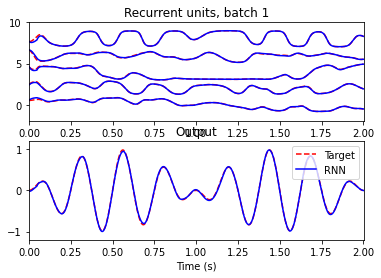

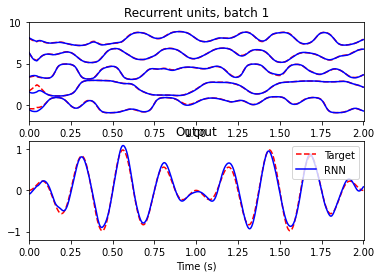

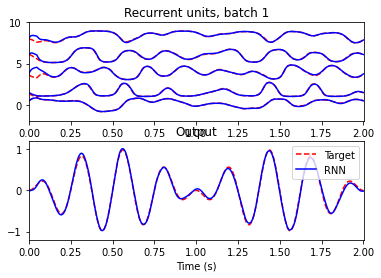

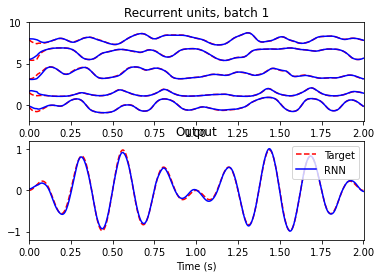

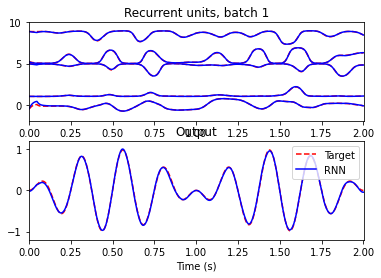

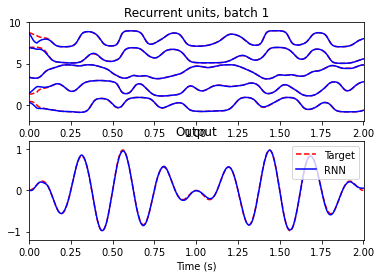

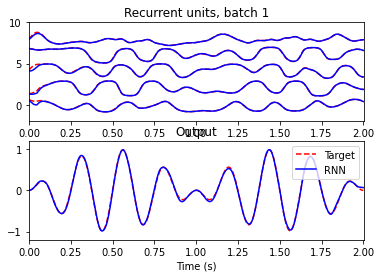

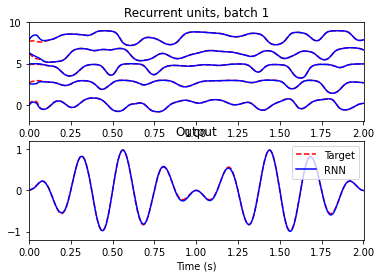

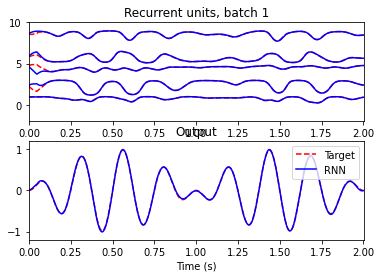

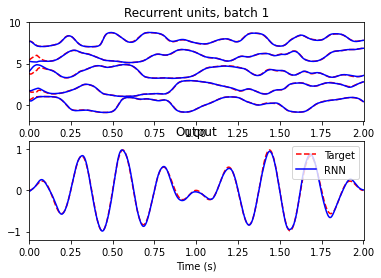

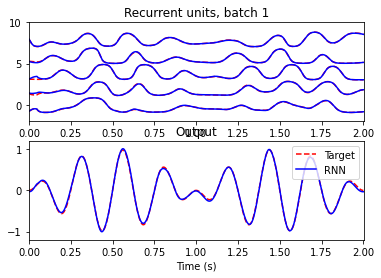

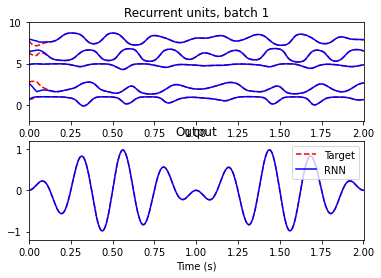

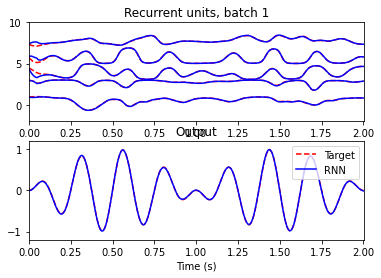

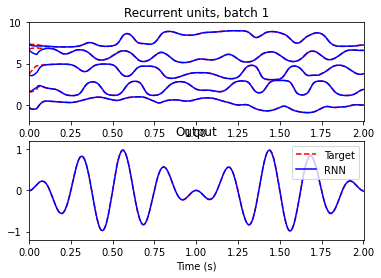

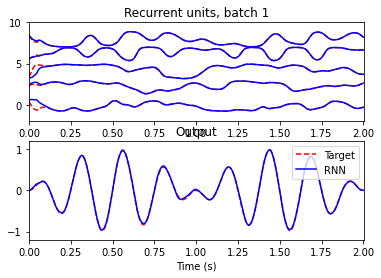

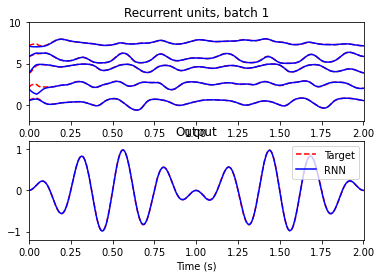

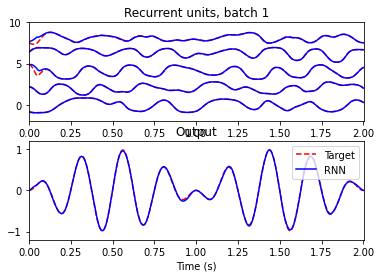

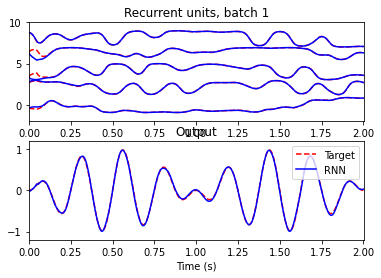

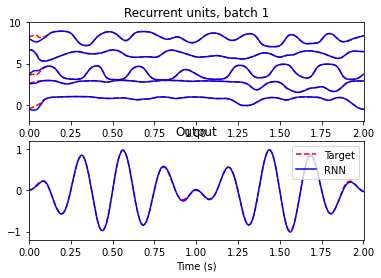

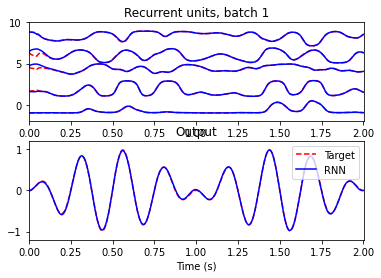

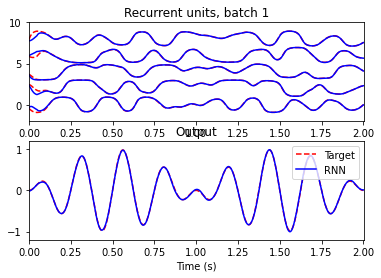

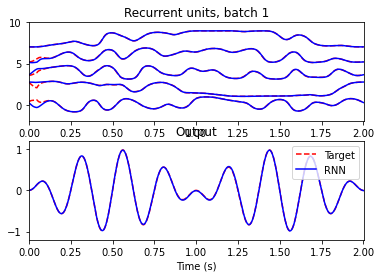

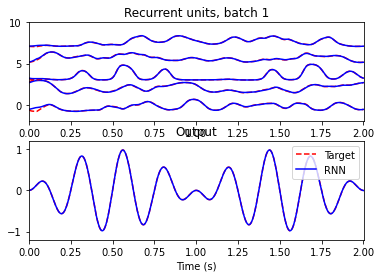

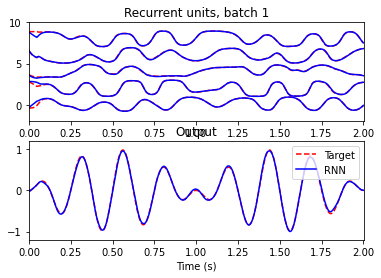

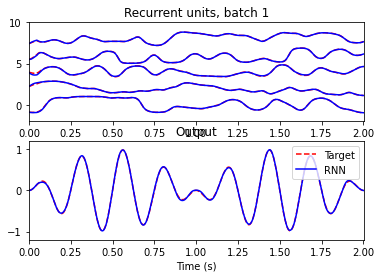

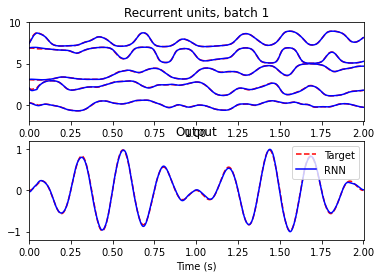

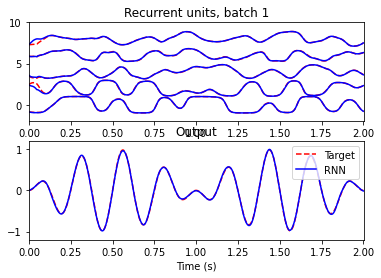

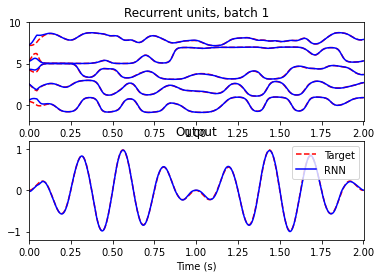

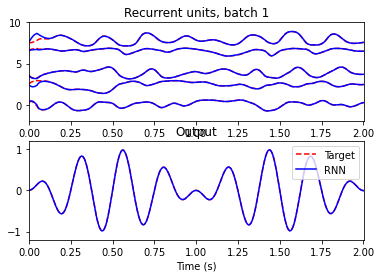

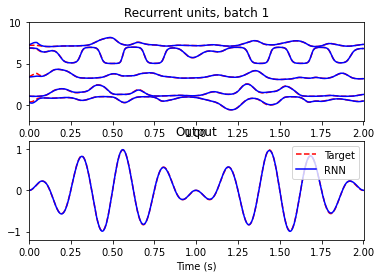

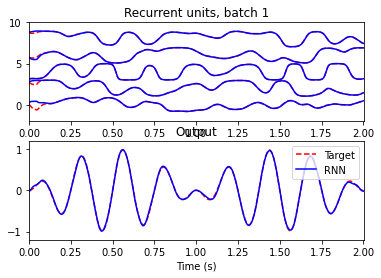

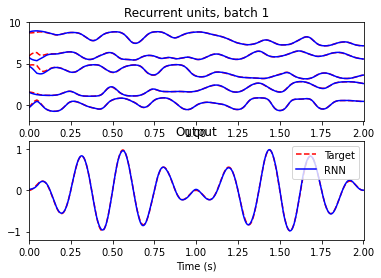

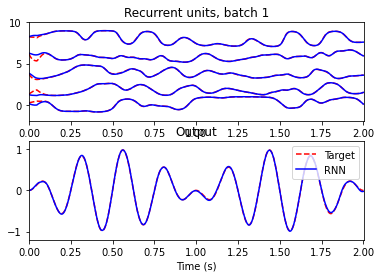

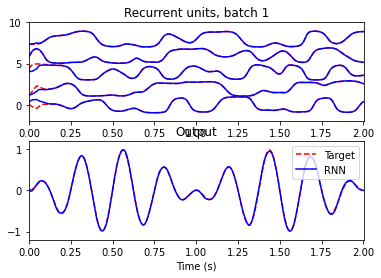

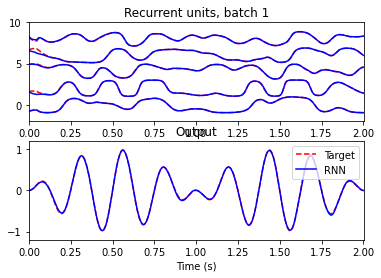

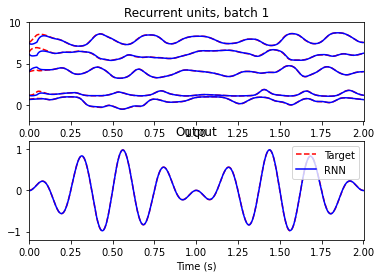

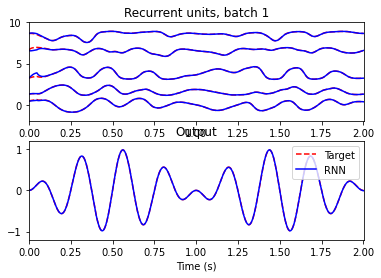

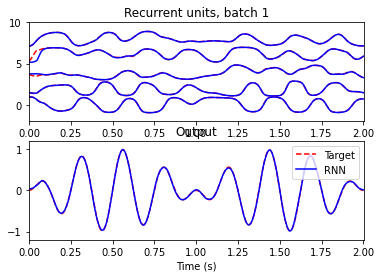

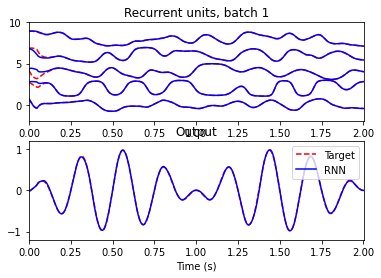

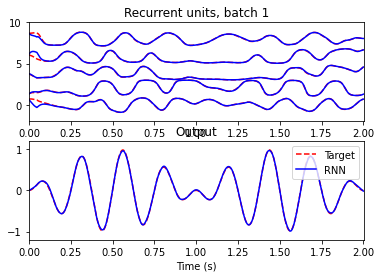

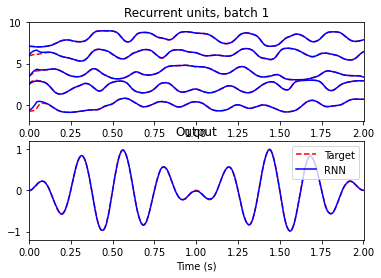

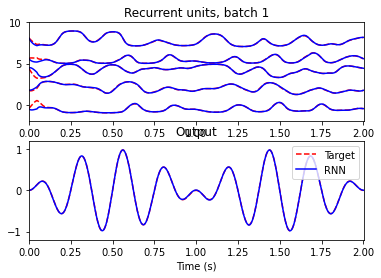

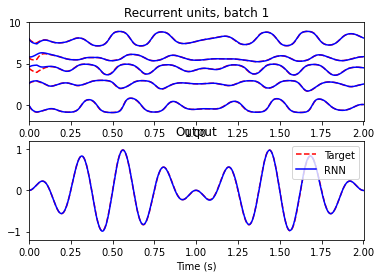

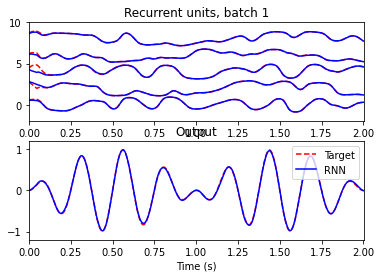

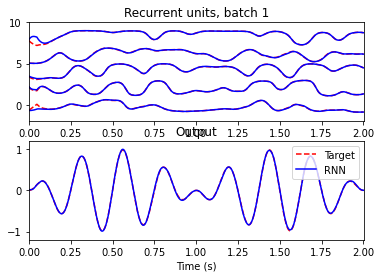

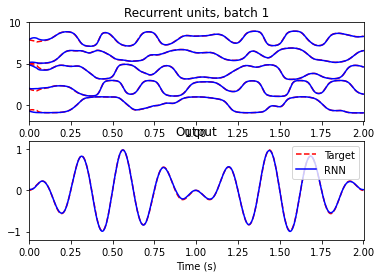

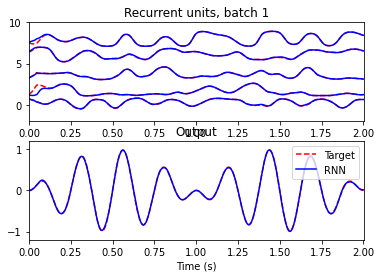

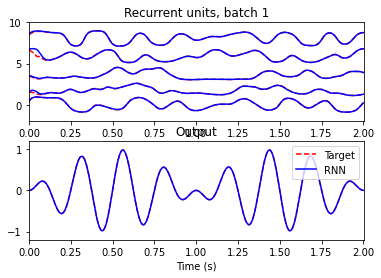

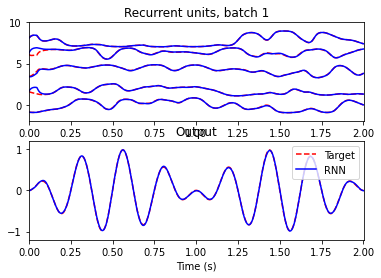

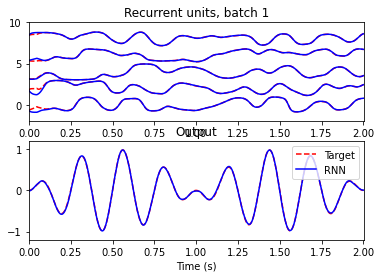

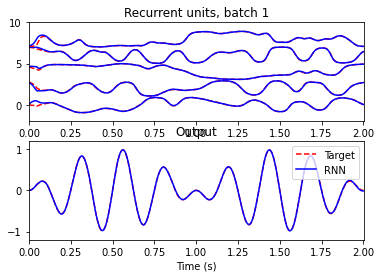

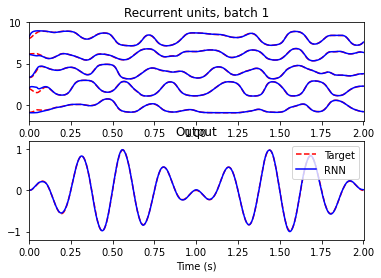

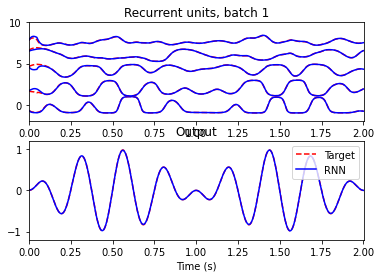

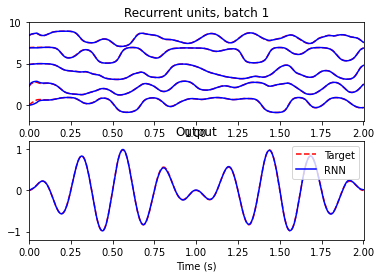

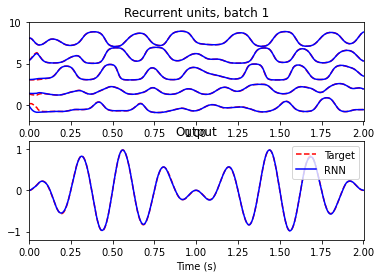

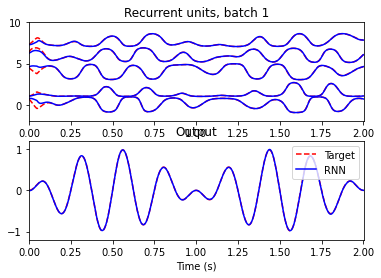

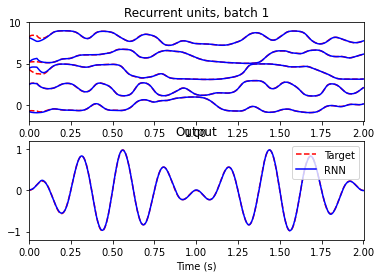

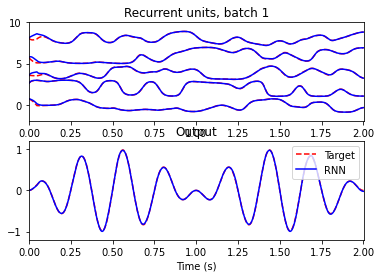

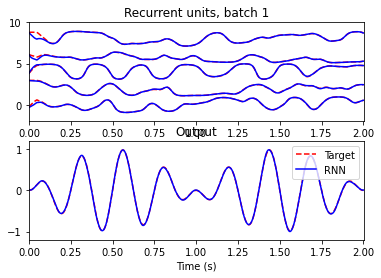

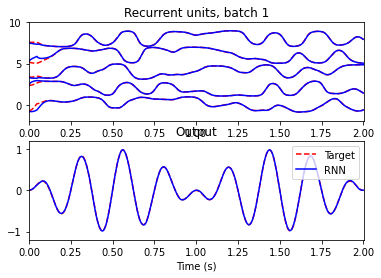

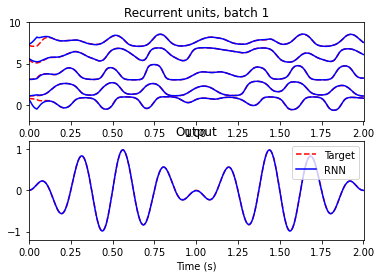

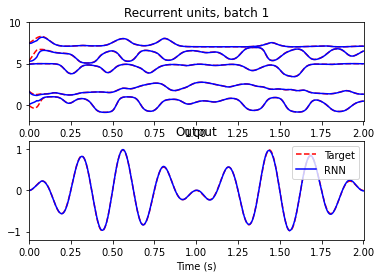

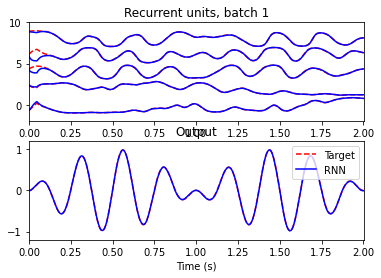

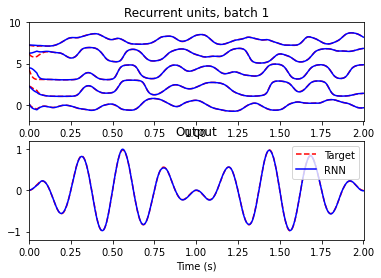

In [9]:
%%time
paper_time_total = np.zeros((len(recur_neuron_list), 3))
for n_iter, n_recur in enumerate(recur_neuron_list):
  paper_time = []
  for i in range(n_trial):  
      p = FF_Demo.create_parameters(dt=dt)
      p['g'] = 1.5 # From paper
      p['network_size'] = n_recur
      p['tau'] = tau
      p['ff_num_batches'] = 1
      p['ff_trials_per_batch'] = n_epoch
      p['ff_steps_per_update'] = 1

      rnn = FF_Demo.RNN(p,1,m)
      start = time.time()
      rnn.train(fullforce_oscillation_test, monitor_training=0)
      paper_time.append((time.time() - start) / n_epoch)

  assert len(paper_time) == n_trial
  paper_time_total[n_iter,0] = n_recur
  paper_time_total[n_iter,1] = np.mean(paper_time)
  paper_time_total[n_iter,2] = np.std(paper_time, ddof=1)

In [10]:
import seaborn as sns
sns.set(context='talk', style='ticks')

In [11]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
EXTRA_SIZE = 24
 
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=EXTRA_SIZE)  # fontsize of the figure title

In [12]:
assert np.allclose(tensorforce_time[:,0],paper_time_total[:,0])

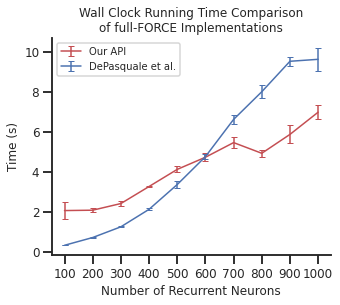

In [13]:
fig, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(5,4))

ax1.errorbar(tensorforce_time[:,0], tensorforce_time[:,1], yerr=tensorforce_time[:,2], label='Our API', color='r', linewidth=1.5, capsize=3)
ax1.errorbar(paper_time_total[:,0], paper_time_total[:,1], yerr=paper_time_total[:,2], label='DePasquale et al.', color='b', linewidth=1.5, capsize=3)

ax1.set_xticks(tensorforce_time[:,0])
ax1.set_xlabel('Number of Recurrent Neurons')
ax1.set_ylabel('Time (s)')
ax1.legend(loc='upper left')
ax1.set_title('Wall Clock Running Time Comparison\nof full-FORCE Implementations')

sns.despine(ax=ax1)